# 1.) Import the data from CCLE into a new Google Colab file

In [25]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt

In [26]:
drive.mount('/content/gdrive/', force_remount = True)

Mounted at /content/gdrive/


In [27]:
df = pd.read_csv("/content/gdrive/MyDrive/ECON441B/insurance.csv")

In [28]:
df.loc[df["sex"] == "female","sex"] = 1.
df.loc[df["sex"] == "male","sex"] = 0.
df.loc[df["smoker"] == "yes","smoker"] = 1.
df.loc[df["smoker"] == "no","smoker"] = 0.

df.loc[df["region"]=="southwest","is_southwest"]=1
df.loc[df["region"]!="southwest","is_southwest"]=0
df.loc[df["region"]=="northwest","is_northwest"]=1
df.loc[df["region"]!="northwest","is_northwest"]=0
df.loc[df["region"]=="southeast","is_southeast"]=1
df.loc[df["region"]!="southeast","is_southeast"]=0
df.loc[df["region"]=="northeast","is_northeast"]=1
df.loc[df["region"]!="northeast","is_northeast"]=0

### Do the same for smoker, region

In [29]:
df.head()

,age,sex,bmi,children,smoker,region,charges,is_southwest,is_northwest,is_southeast,is_northeast
0,19,1.0,27.900,0,1.0,southwest,16884.92400,1.0,0.0,0.0,0.0
1,18,0.0,33.770,1,0.0,southeast,1725.55230,0.0,0.0,1.0,0.0
2,28,0.0,33.000,3,0.0,southeast,4449.46200,0.0,0.0,1.0,0.0
3,33,0.0,22.705,0,0.0,northwest,21984.47061,0.0,1.0,0.0,0.0
4,32,0.0,28.880,0,0.0,northwest,3866.85520,0.0,1.0,0.0,0.0


# 2.) Split the data into 80/20, in/out sample

In [30]:
import numpy as np

In [72]:
data = np.array(df.iloc[:,[0,1,2,3,4,7,8,9]])
target = np.array(df.iloc[:,-5])

In [73]:
data

array([[19, 1.0, 27.9, ..., 1.0, 0.0, 0.0],
       [18, 0.0, 33.77, ..., 0.0, 0.0, 1.0],
       [28, 0.0, 33.0, ..., 0.0, 0.0, 1.0],
       ...,
       [18, 1.0, 36.85, ..., 0.0, 0.0, 1.0],
       [21, 1.0, 25.8, ..., 1.0, 0.0, 0.0],
       [61, 1.0, 29.07, ..., 0.0, 1.0, 0.0]], dtype=object)

In [74]:
cut = int((len(data) * .8) // 1)

In [75]:
in_data = data[:cut]
out_data = data[cut:]
in_target = target[:cut]
out_target = target[cut:]

# 3.) Normalize the Data

In [76]:
from sklearn import preprocessing

In [77]:
scaler = preprocessing.StandardScaler().fit(in_data)
in_data_scale = scaler.transform(in_data)

out_data_scale = scaler.transform(out_data)

In [78]:
in_data_scale

array([[-1.45390122,  1.02077653, -0.47403991, ...,  1.76504522,
        -0.55791981, -0.6155209 ],
       [-1.52464584, -0.97964634,  0.4911621 , ..., -0.56655772,
        -0.55791981,  1.6246402 ],
       [-0.81719959, -0.97964634,  0.36455128, ..., -0.56655772,
        -0.55791981,  1.6246402 ],
       ...,
       [-0.03900872, -0.97964634,  1.95211949, ..., -0.56655772,
        -0.55791981, -0.6155209 ],
       [ 1.65886228, -0.97964634, -1.50008089, ..., -0.56655772,
         1.79237229, -0.6155209 ],
       [ 1.02216066,  1.02077653,  0.18367867, ..., -0.56655772,
        -0.55791981,  1.6246402 ]])

# 4.) Get lambda from Lasso cross validation

In [79]:
from sklearn.linear_model import LassoCV

In [80]:
# Import LassoCV

modCV = LassoCV().fit(in_data_scale,in_target)

In [81]:
a=modCV.alpha_

In [82]:
a

115.9799859390741

# 5.) Run a lasso regression with that Lambda

In [83]:
# Use Lasso

In [84]:
from sklearn.linear_model import Lasso

In [92]:
model1=Lasso(alpha=a).fit(in_data_scale,in_target)
model1.predict(np.array(in_data_scale))
model1.coef_

array([3580.35805206,    0.        , 1897.42890992,  415.06890389,
       9345.10115447, -238.7634887 ,   -0.        , -158.68185954])

# 6.) Visualize the coefficients 

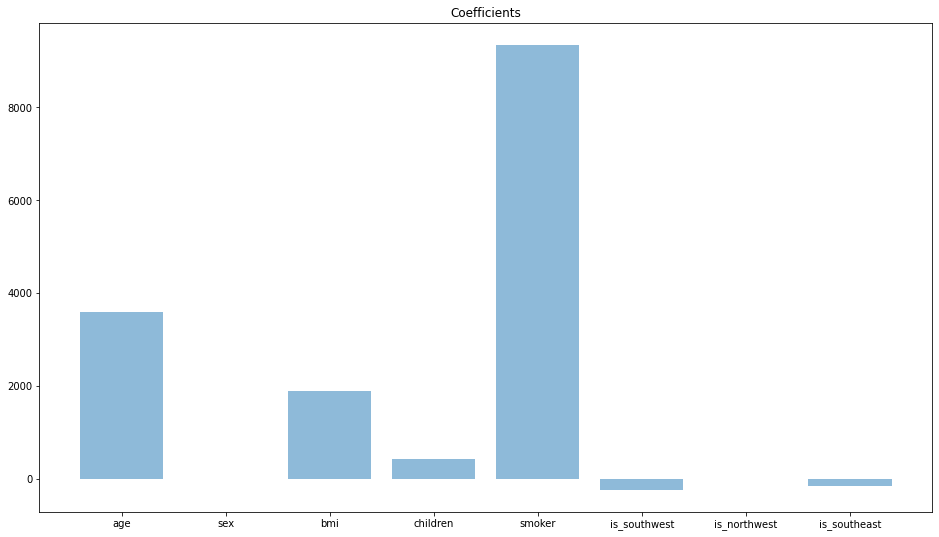

In [93]:
objects = ('age', 'sex', 'bmi','children','smoker','is_southwest','is_northwest','is_southeast')
y_pos = np.arange(len(objects))
plt.figure(figsize=(16, 9))
plt.bar(y_pos, model1.coef_, align='center', alpha=0.5)
plt.xticks(y_pos,objects)
plt.title('Coefficients')
plt.show()

# 7.) Interpret the coefficients

The graph shows that age considerably impacts health insurance spending since older people have the propensity to spend more on health insurance. Second, the cost of health insurance is significantly influenced by BMI. The cost of health insurance increases as BMI increases. The cost of insurance is mostly unaffected by gender, with males spending somewhat more than women. On the other hand, smokers are more than willing to pay for health insurance. Children tend to make insurance contributions. Compared to other regions, people in the Northeast are more likely to get health insurance.


# 8.) Compare in and out of sample MSE’s

In [87]:
#mod1.predict("in sample data")
#mod1.predict("out of sample data")

In [88]:
in_y_pred=model1.predict(np.array(in_data_scale))
out_y_pred=model1.predict(np.array(out_data_scale))

In [89]:
from sklearn.metrics import mean_squared_error
out_sample_mse = mean_squared_error(out_y_pred,out_target)
in_sample_mse=mean_squared_error(in_y_pred,in_target)

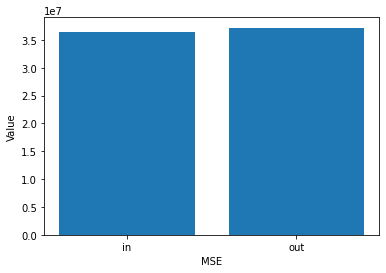

In [91]:
plt.bar(["in","out"],[in_sample_mse,out_sample_mse])
plt.xlabel("MSE")
plt.ylabel("Value")
plt.show()